# Project: Kernel ridge regression

In lecture 12 I showed how the kernel trick can be used to extend ridge regression to the nonlinear setting. The focus of this assignment is to explore the effect of different kernels and their hyperparameters on the methods capabilities.


1. Simulate one- or two-dimensional regression datasets, i.e. one or two features and a single real valued response (to make things easy to visualise in a 2D or 3D plot). Make sure to make the datasets nonlinear to find settings in which normal linear ridge regression would not work.

2. Check your signal-to-noise ratio to make sure it’s in an “interesting” range (> 1 but not over 10)

3. Use kernel ridge regression with different kernels and investigate which kind of nonlinear shapes can be caught. Always cross-validate over the regularisation parameter lambda and either cross-validate over kernel hyperparameters or analyse their impact on the performance.

4. In addition to visualisation, quantify the results (e.g. by simulating a separate validation set and comparing the final cross-validated models on their test set MSE) and find the best kernel for each of your datasets.

5. Make sure to make your datasets challenging enough so that not all tested kernels perform equally well. Start with a simple sine curve and progress to play with combinations of https://en.wikipedia.org/wiki/Sinc_function (Links to an external site.) and other sin/cos functions. Other nonlinear shapes are of course welcome as well.


In [30]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from sklearn import preprocessing, metrics, kernel_ridge
from sklearn.datasets import make_moons, make_circles
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


In [187]:
class dataset():  
    """
    Creates a dataset for kernel ridge regression,
    choose between different y functions.
    """
    
    def __init__(self, n_datapoints, p_coefficients):

        self.X = None
        self.epsilon = None
        self.beta = None
        self.y = None 

        self.n = n_datapoints
        self.p = p_coefficients

        
    def create_data(self, noise_sigma, beta, data_type='sinc',standardise=False):
        self.X = np.random.normal(scale=1, size=(self.n, self.p))
        
        if standardise == True:
            standard_scaled = preprocessing.StandardScaler()
            self.X = standard_scaled.fit_transform(self.X)
        
        self.epsilon = np.random.normal(scale=noise_sigma, size=(self.n))
        self.beta = beta #np.random.normal(scale=1,size=(self.p,1)) #np.ones(shape=(self.p,1))
        
        if data_type=='sinc':

            self.y = np.sum(np.sinc(self.beta*self.X), axis=1) + self.epsilon 
            SNR = np.linalg.norm(np.sinc(self.beta*self.X))/np.linalg.norm(self.epsilon)
            
        elif data_type == 'sinus':
            
            self.y = np.sum(np.sin(self.X*self.beta), axis=1) + self.epsilon 
            SNR = np.linalg.norm(np.sin(self.X*self.beta))/np.linalg.norm(self.epsilon)
        
        elif data_type == 'arctan':
            
            self.y = np.sum(np.arctan(self.beta/self.X), axis=1) + self.epsilon 
            SNR = np.linalg.norm(np.arctan(self.beta/self.X))/np.linalg.norm(self.epsilon)
        
        elif data_type == 'cosine^2':
            
            self.y = np.sum(np.cos(self.beta*self.X**2), axis=1) + self.epsilon 
            SNR = np.linalg.norm(np.cos(self.beta*self.X**2))/np.linalg.norm(self.epsilon)
       
        elif data_type == 'X^3':
            
            self.y = np.sum(np.dot(self.X**3, self.beta), axis=1) + self.epsilon
            SNR = np.linalg.norm( np.dot(self.X**3, self.beta) ) / np.linalg.norm(self.epsilon)
            
        elif data_type == 'sin+cos':
            
            self.y = np.sum((np.sin(self.X) + np.cos(self.X**2))*self.beta, axis=1) + self.epsilon
            SNR = np.linalg.norm( (np.sin(self.X) + np.cos(self.X**2))*self.beta ) / np.linalg.norm(self.epsilon)
        
        elif data_type == 'circle':
            
            circles, lables = make_circles(n_samples=self.n, noise=noise_sigma)
            self.X = circles[:,0]
            self.y = circles[:,1]
            SNR = None
        print('SNR = ', SNR)   

In [200]:
def kernel_ridge_regression(X_train, y_train, X_test, y_test, alpha, gamma, kernel, d=3):
    
    clf = kernel_ridge.KernelRidge(alpha, kernel, gamma, degree=d)
    clf.fit(X_train, y_train)
    
    y_predict = clf.predict(X_test)
    
    MSE = metrics.mean_squared_error(y_test, y_predict)
    
    return MSE, y_predict

def CV_coefficient(X_train, y_train, X_test, y_test, kernel, alpha, gamma, plot=False):
    alpha_vector = np.linspace(alpha[0],alpha[1], 20)
    gamma_vector = np.linspace(gamma[0],gamma[1], 20)
    MSE_matrix = []
    
    if kernel != 'polynomial':
        print(kernel)
        
        for g, i in zip(gamma_vector, range(len(gamma_vector))):
            MSE_matrix.append([])

            for a in alpha_vector:
                MSE = kernel_ridge_regression(X_train, y_train, X_test, y_test, a, g, kernel)[0]
                MSE_matrix[i].append(MSE)

        MSE_matrix = np.array(MSE_matrix)

        optimal_gamma_index, optimal_alpha_index = np.unravel_index(np.argmin(MSE_matrix, axis=None), MSE_matrix.shape)
        optimal_alpha = alpha_vector[optimal_alpha_index]
        optimal_gamma = gamma_vector[optimal_gamma_index]
    
    else:
        
        degree_list = [1*i for i in range(3,20)]
        optimal_parameters = {}
        degree_to_MSE = {}
        MSE_min = []
        for degree in degree_list:
            degree= int(degree)
            MSE_matrix = []

            for g, i in zip(gamma_vector, range(len(gamma_vector))):
                MSE_matrix.append([])

                for a in alpha_vector:
                    MSE = kernel_ridge_regression(X_train, y_train, X_test, y_test, a, g, kernel, degree)[0]
                    MSE_matrix[i].append(MSE)
                    
            MSE_matrix = np.array(MSE_matrix)
            MSE_min.append(np.min(MSE_matrix))
            
            optimal_gamma_index, optimal_alpha_index = np.unravel_index(np.argmin(MSE_matrix, axis=None), MSE_matrix.shape)
            optimal_alpha = alpha_vector[optimal_alpha_index]
            optimal_gamma = gamma_vector[optimal_gamma_index]
            optimal_parameters[degree] = (optimal_alpha,optimal_gamma)
        
        optimal_degree = degree_list[np.argmin(MSE_min)]
        optimal_alpha, optimal_gamma = optimal_parameters[optimal_degree]
    
    if plot==True:
        MSE_pd = pd.DataFrame(MSE_matrix, index=np.round(gamma_vector,3), columns=np.round(alpha_vector,3))        
        plt.figure()
        ax = sns.heatmap(MSE_pd)
        plt.title(f'kernel={kernel}' )
        plt.ylabel("gamma")
        plt.xlabel("alpha")
    
    if kernel != 'polynomial':
        return optimal_alpha, optimal_gamma
    else:
        return optimal_alpha, optimal_gamma, optimal_degree
        

def run_script(X_train, X_test, y_train, y_test):
    kernel_list = ['polynomial', 'linear', 'laplacian', 'rbf', 'sigmoid']

    for kernel in kernel_list:

        if kernel != 'polynomial':
            optimal_alpha, optimal_gamma = CV_coefficient(X_train, y_train, X_test, y_test, kernel, alpha, gamma)
            MSE, y_predict = kernel_ridge_regression(X_train, y_train, X_test, y_test, optimal_alpha, optimal_gamma, kernel)
            print(kernel, 'alpha:',optimal_alpha, 'gamma:', optimal_gamma, 'MSE:', MSE)
            
            fig, ax = plt.subplots(figsize=(10,6))
            plt.scatter(X_test, y_test, label='test data')
            plt.scatter(X_test, y_predict, label='predicted data')
            ax.set_title(f'Predicted vs test data, kernel = {kernel}, \n MSE={np.round(MSE, decimals=4)} \n alpha={np.round(optimal_alpha, decimals=4)}, gamma={np.round(optimal_gamma, decimals=4)}')
            plt.legend()
            plt.show()
        else:
            optimal_alpha, optimal_gamma, optimal_degree = CV_coefficient(X_train, y_train, X_test, y_test, kernel, alpha, gamma)
            MSE, y_predict = kernel_ridge_regression(X_train, y_train, X_test, y_test, optimal_alpha, optimal_gamma, kernel, optimal_degree)
            print(kernel, ' degree:', optimal_degree,' alpha:',optimal_alpha, ' gamma:', optimal_gamma, ' MSE:', MSE)
            
            fig, ax = plt.subplots(figsize=(10,6))
            plt.scatter(X_test, y_test, label='test data')
            plt.scatter(X_test, y_predict, label='predicted data')
            ax.set_title(f'Predicted vs test data, kernel = {kernel}, \n MSE={np.round(MSE,decimals=4)}, degree={np.round(optimal_degree, decimals=4)} \n alpha={np.round(optimal_alpha, decimals=4)}, gamma={np.round(optimal_gamma, decimals=4)}')
            plt.legend()
            plt.show()

SNR =  3.1031425126971985


Text(0, 0.5, 'y')

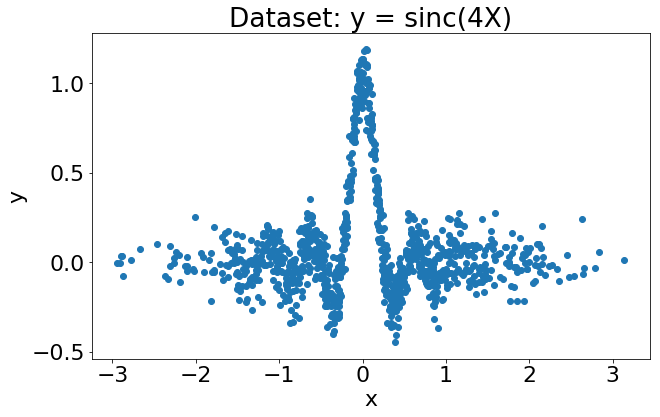

In [201]:
# sinc dataset
noise_sigma = 0.1
beta = 4
data_type='sinc'

data_sinc = dataset(1000,1)
data_sinc.create_data(noise_sigma, beta, data_type,standardise=False)
X = data_sinc.X
y = data_sinc.y.ravel()
X_train, X_test = X[:800], X[800:]
y_train, y_test = y[:800], y[800:]

gamma = [0.001, 40]
alpha=[0.001, 40]

fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(X[:,0],y)
ax.set_title(f'Dataset: y = sinc({beta}X)')
ax.set_xlabel('x')
ax.set_ylabel('y')

polynomial  degree: 12  alpha: 4.21142105263158  gamma: 2.1062105263157895  MSE: 0.0775817611156279


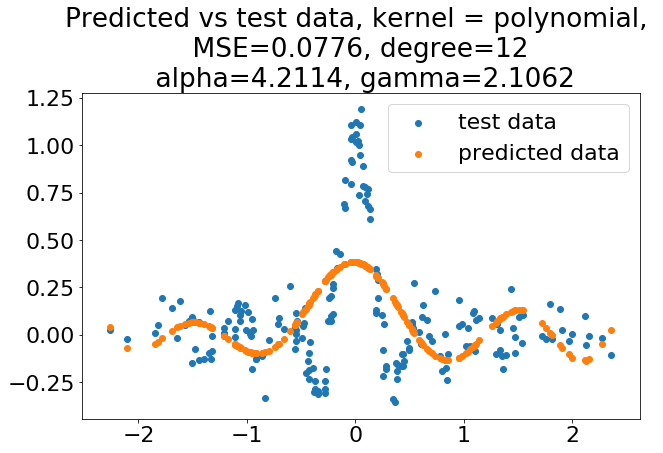

linear
linear alpha: 0.001 gamma: 0.001 MSE: 0.12892846827279011


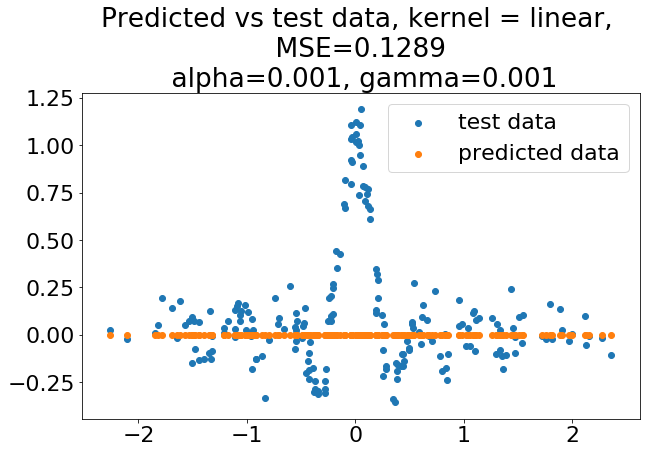

laplacian
laplacian alpha: 2.1062105263157895 gamma: 8.421842105263158 MSE: 0.010511993532557756


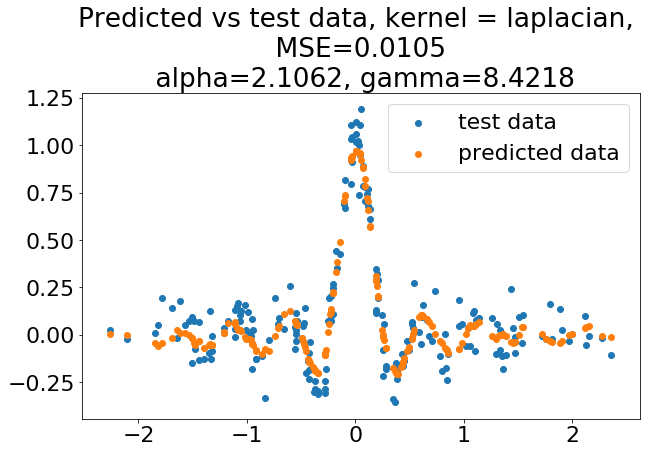

rbf
rbf alpha: 0.001 gamma: 4.21142105263158 MSE: 0.009748194017190927


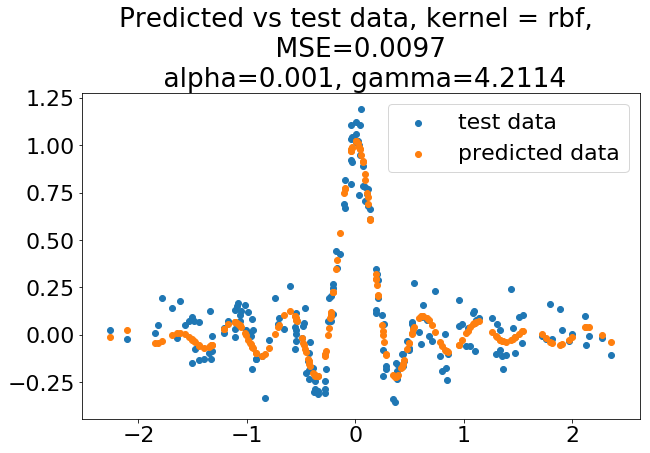

sigmoid
sigmoid alpha: 0.001 gamma: 8.421842105263158 MSE: 0.009868992110422262


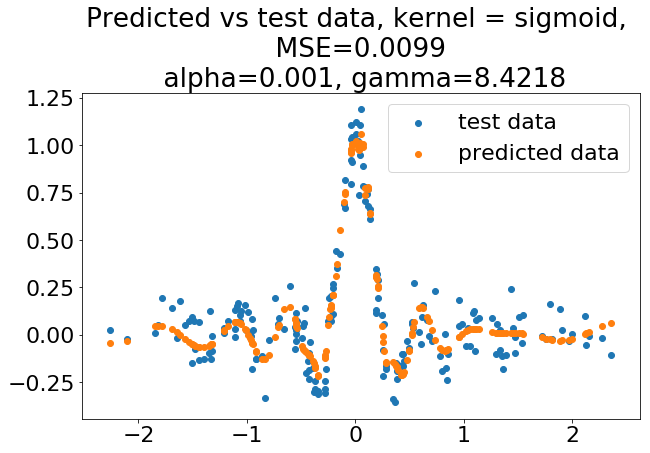

In [202]:
run_script(X_train, X_test, y_train, y_test)

SNR =  5.174214208306045


Text(0, 0.5, 'y')

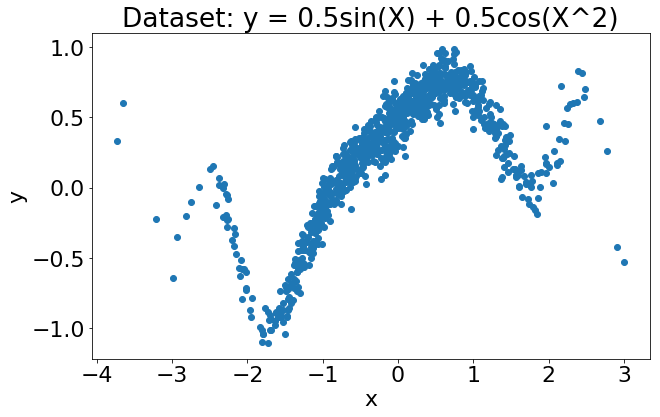

In [203]:
# tan dataset
noise_sigma = 0.1
beta = 0.5
data_type='sin+cos'

data_sinc = dataset(1000,1)
data_sinc.create_data(noise_sigma, beta, data_type,standardise=False)
X = data_sinc.X
y = data_sinc.y.ravel()
X_train, X_test = X[:800], X[800:]
y_train, y_test = y[:800], y[800:]

gamma = [0.001, 40]
alpha=[0.001, 40]

fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(X[:,0],y)
ax.set_title(f'Dataset: y = {beta}sin(X) + {beta}cos(X^2)')
ax.set_xlabel('x')
ax.set_ylabel('y')

polynomial  degree: 12  alpha: 12.632263157894737  gamma: 2.1062105263157895  MSE: 0.011666552853202606


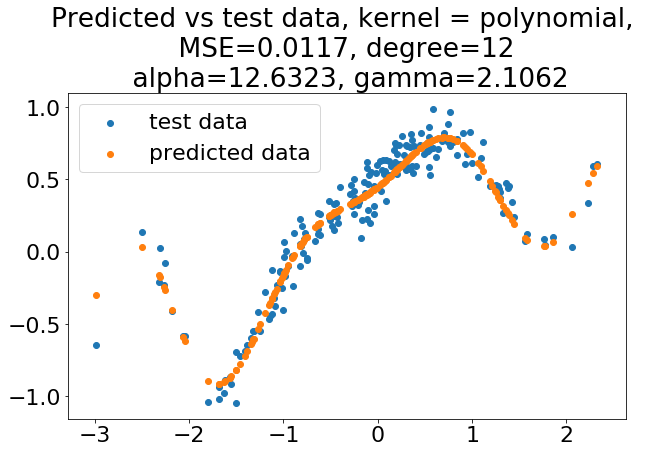

linear
linear alpha: 0.001 gamma: 0.001 MSE: 0.1963325393008606


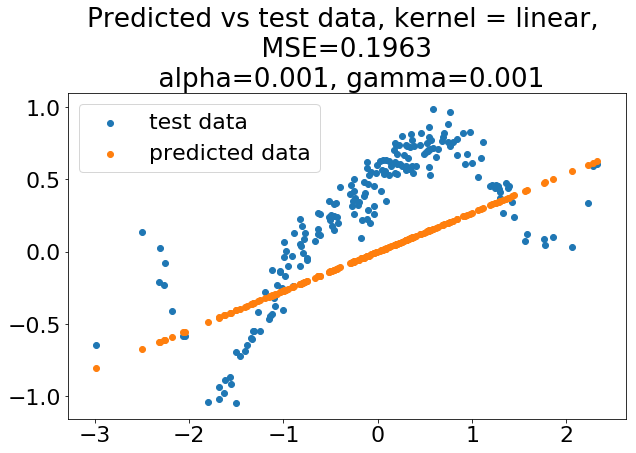

laplacian
laplacian alpha: 0.001 gamma: 0.001 MSE: 0.011956177313629333


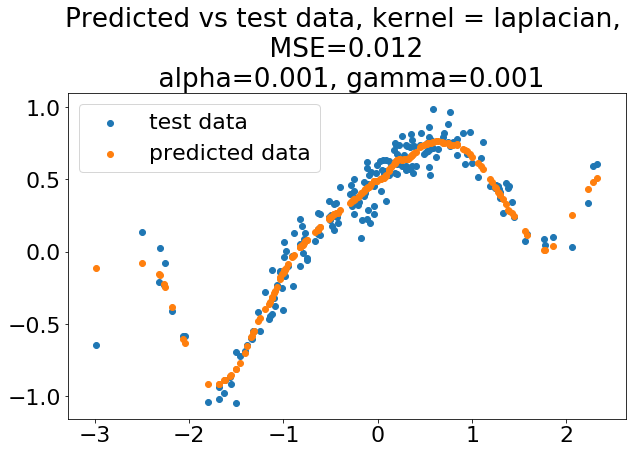

rbf
rbf alpha: 0.001 gamma: 2.1062105263157895 MSE: 0.010375976634269616


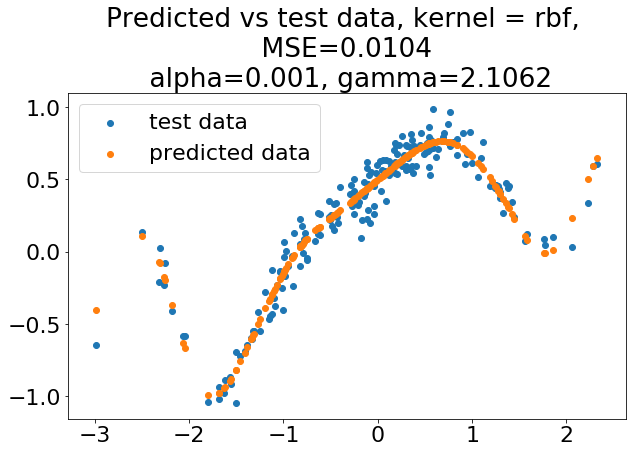

sigmoid
sigmoid alpha: 0.001 gamma: 8.421842105263158 MSE: 0.01119057093071179


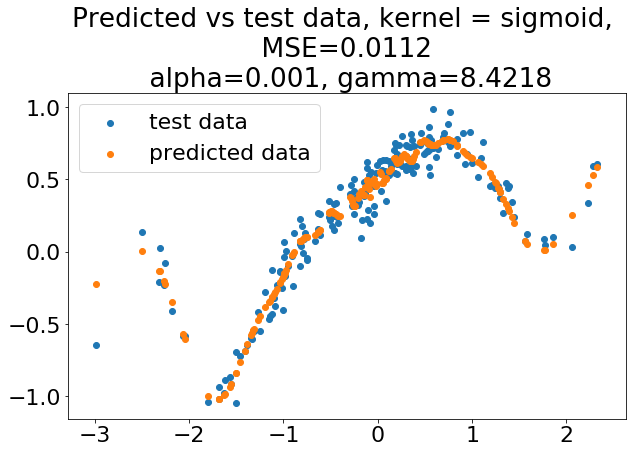

In [204]:
run_script(X_train, X_test, y_train, y_test)

SNR =  6.391339528822968


Text(0, 0.5, 'y')

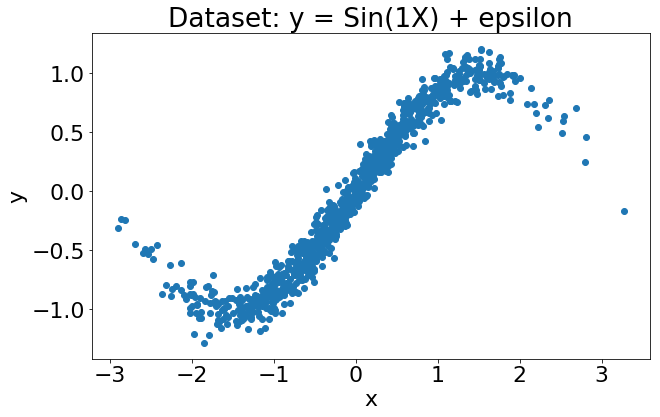

In [205]:
#sinus data
noise_sigma = 0.1
beta = 1
data_type='sinus'

data_sinc = dataset(1000,1)
data_sinc.create_data(noise_sigma, beta, data_type,standardise=False)
X = data_sinc.X
y = data_sinc.y.ravel()
X_train, X_test = X[:800], X[800:]
y_train, y_test = y[:800], y[800:]

gamma = [0.001, 40]
alpha=[0.001, 40]

fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(X[:,0],y)
ax.set_title(f'Dataset: y = Sin({beta}X) + epsilon')
ax.set_xlabel('x')
ax.set_ylabel('y')

polynomial  degree: 6  alpha: 0.001  gamma: 10.527052631578949  MSE: 0.009634560071014922


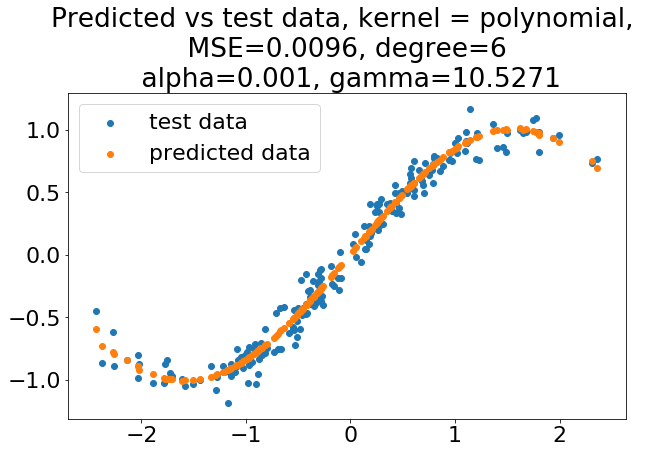

linear
linear alpha: 0.001 gamma: 0.001 MSE: 0.05722458757099913


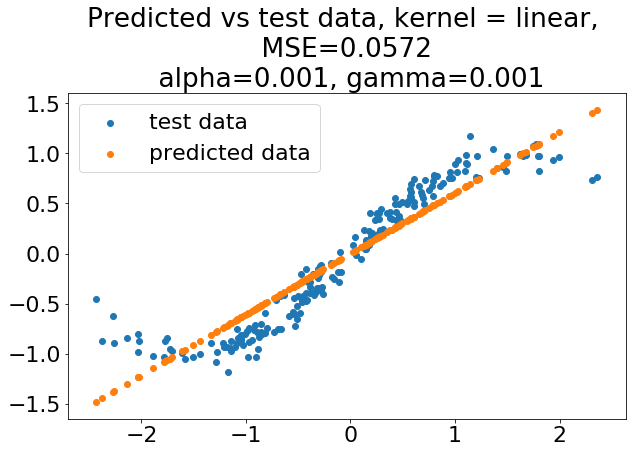

laplacian
laplacian alpha: 0.001 gamma: 0.001 MSE: 0.00982263132358669


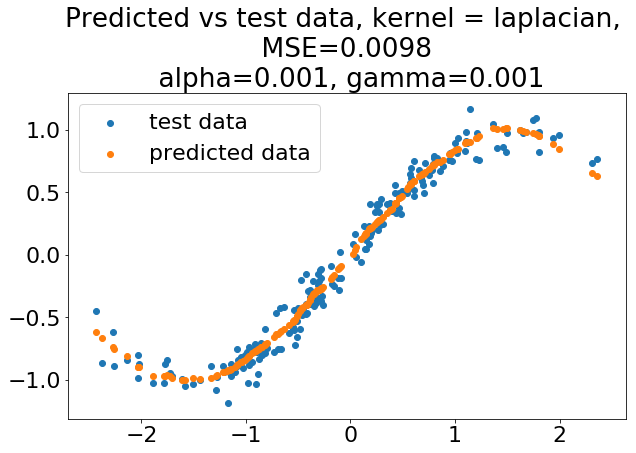

rbf
rbf alpha: 0.001 gamma: 23.158315789473686 MSE: 0.009853472311749151


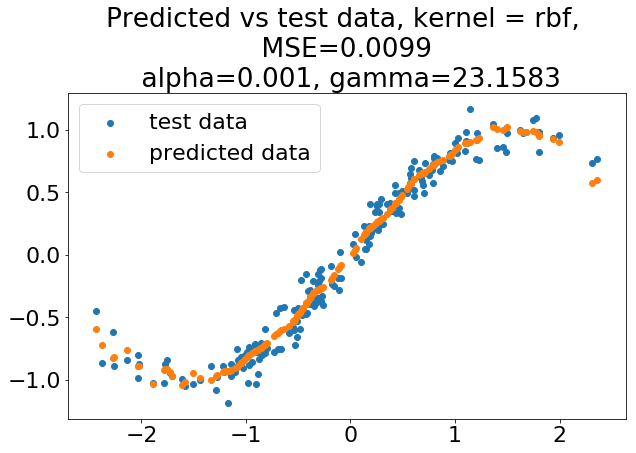

sigmoid
sigmoid alpha: 0.001 gamma: 4.21142105263158 MSE: 0.010050477091405621


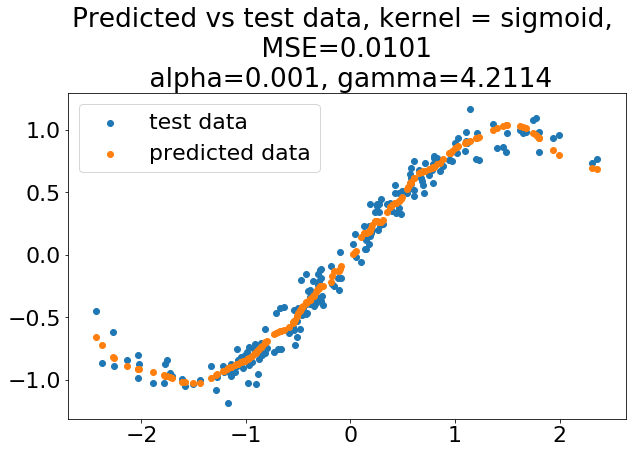

In [206]:
run_script(X_train, X_test, y_train, y_test)

SNR =  7.8511233362764


Text(0, 0.5, 'y')

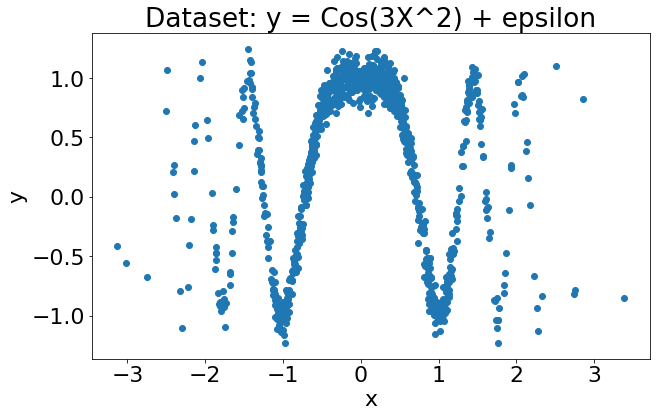

In [207]:
#cosinus data
noise_sigma = 0.1
beta = 3
data_type='cosine^2'

data_sinc = dataset(1000,1)
data_sinc.create_data(noise_sigma, beta, data_type,standardise=False)
X = data_sinc.X
y = data_sinc.y.ravel()
X_train, X_test = X[:800], X[800:]
y_train, y_test = y[:800], y[800:]

gamma = [0.001, 50]
alpha=[0.001, 50]

fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(X[:,0],y)
ax.set_title(f'Dataset: y = Cos({beta}X^2) + epsilon')
ax.set_xlabel('x')
ax.set_ylabel('y')

polynomial  degree: 12  alpha: 15.790157894736842  gamma: 2.6325263157894736  MSE: 0.19527536809391857


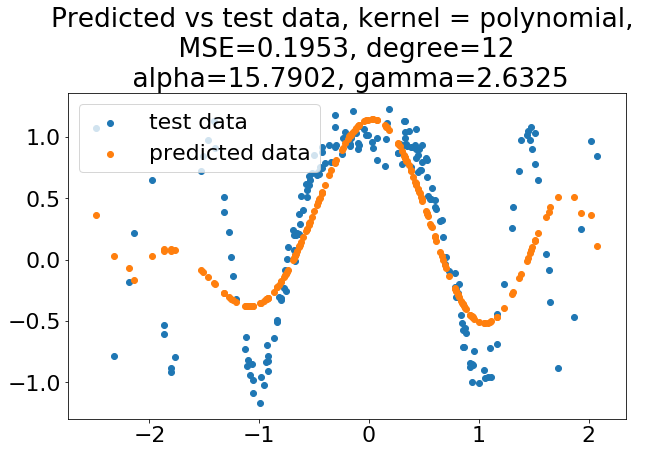

linear
linear alpha: 0.001 gamma: 0.001 MSE: 0.5799341909703698


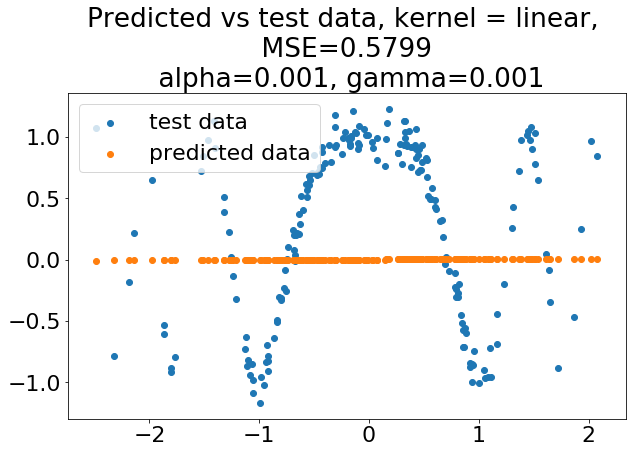

laplacian
laplacian alpha: 0.001 gamma: 2.6325263157894736 MSE: 0.017628961668661635


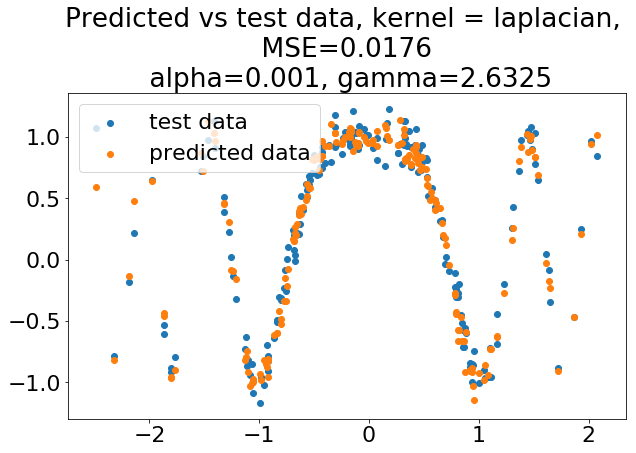

rbf
rbf alpha: 0.001 gamma: 10.527105263157894 MSE: 0.010049417809147304


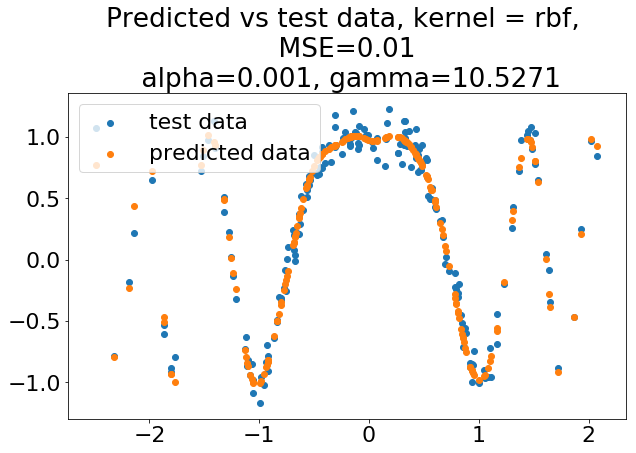

sigmoid
sigmoid alpha: 0.001 gamma: 5.264052631578948 MSE: 0.06214882260743386


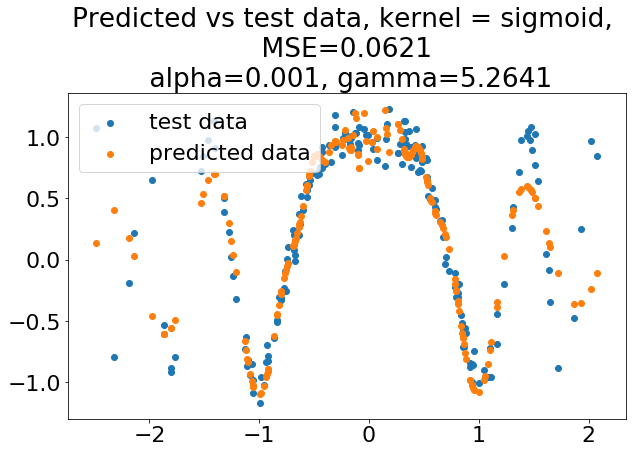

In [208]:
run_script(X_train, X_test, y_train, y_test)

SNR =  None


Text(0, 0.5, 'y')

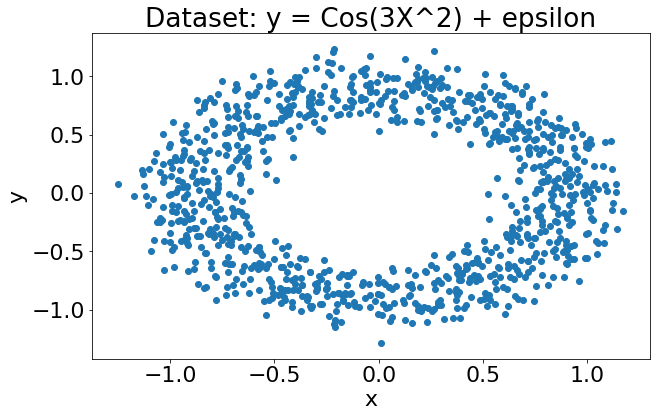

In [209]:
#cosinus data
noise_sigma = 0.1
beta = 3
data_type='circle'

data_sinc = dataset(1000,1)
data_sinc.create_data(noise_sigma, beta, data_type,standardise=False)
X = data_sinc.X.reshape(-1, 1)
y = data_sinc.y.ravel()
X_train, X_test = X[:800], X[800:]
y_train, y_test = y[:800], y[800:]

gamma = [0.001, 50]
alpha=[0.001, 50]

fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(X,y)
ax.set_title(f'Dataset: y = Cos({beta}X^2) + epsilon')
ax.set_xlabel('x')
ax.set_ylabel('y')

polynomial  degree: 18  alpha: 26.31626315789474  gamma: 7.8955789473684215  MSE: 0.4229502772071752


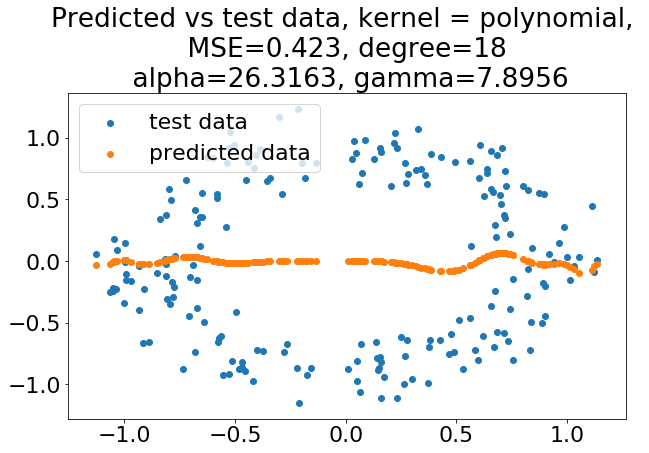

linear
linear alpha: 50.0 gamma: 0.001 MSE: 0.42655111042938926


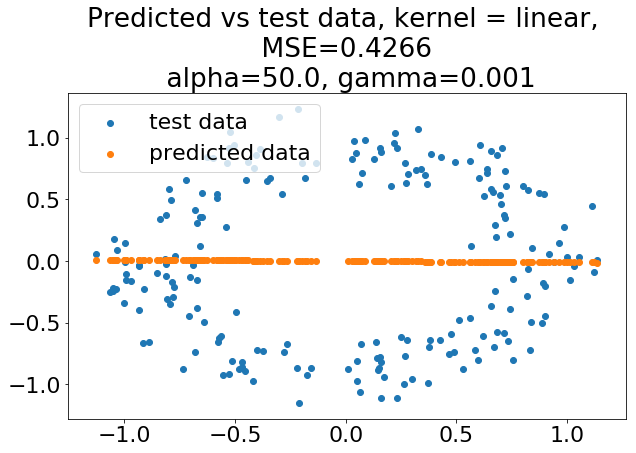

laplacian
laplacian alpha: 50.0 gamma: 0.001 MSE: 0.4259742995373901


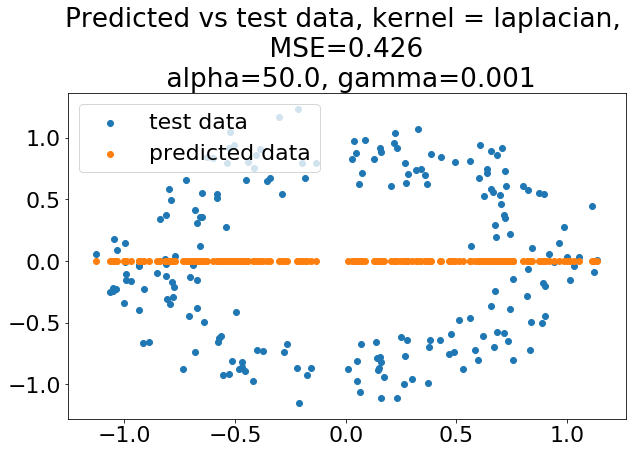

rbf
rbf alpha: 50.0 gamma: 0.001 MSE: 0.42597809428946376


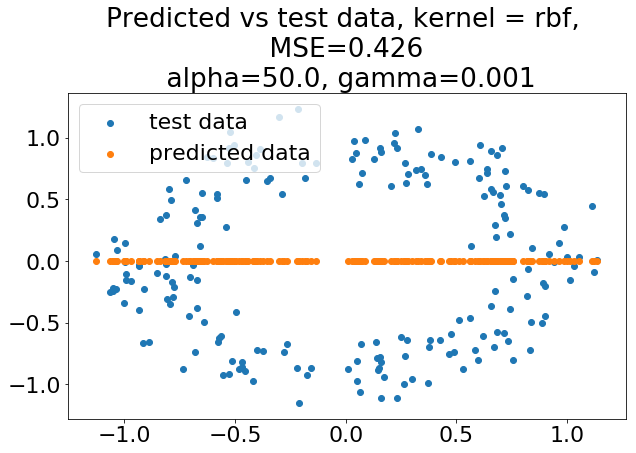

sigmoid
sigmoid alpha: 50.0 gamma: 0.001 MSE: 0.42597157348682446


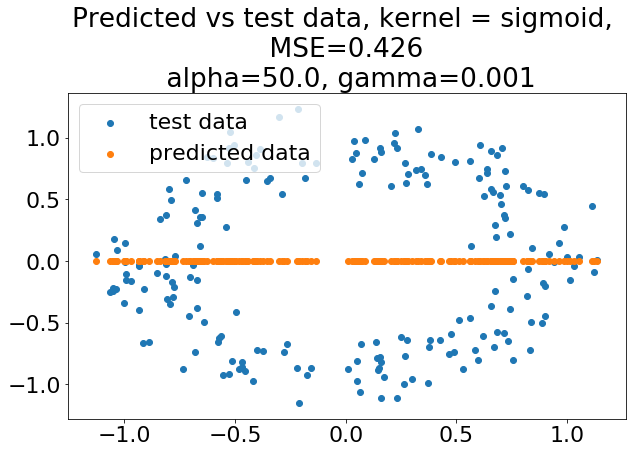

In [210]:
run_script(X_train, X_test, y_train, y_test)

SNR =  5.78919676798956


Text(0, 0.5, 'y')

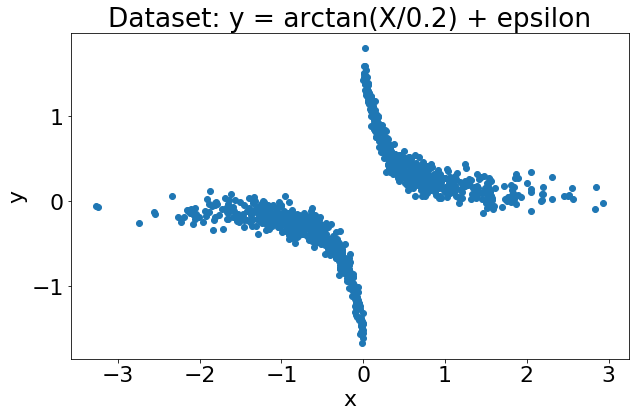

In [211]:
#arctan data
noise_sigma = 0.1
beta = 0.2
data_type='arctan'

data_sinc = dataset(1000,1)
data_sinc.create_data(noise_sigma, beta, data_type,standardise=False)
X = data_sinc.X
y = data_sinc.y.ravel()
X_train, X_test = X[:800], X[800:]
y_train, y_test = y[:800], y[800:]

gamma = [0.001, 40]
alpha=[0.001, 40]

fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(X[:,0],y)
ax.set_title(f'Dataset: y = arctan(X/{beta}) + epsilon')
ax.set_xlabel('x')
ax.set_ylabel('y')

polynomial  degree: 13  alpha: 4.21142105263158  gamma: 2.1062105263157895  MSE: 0.24314673533276326


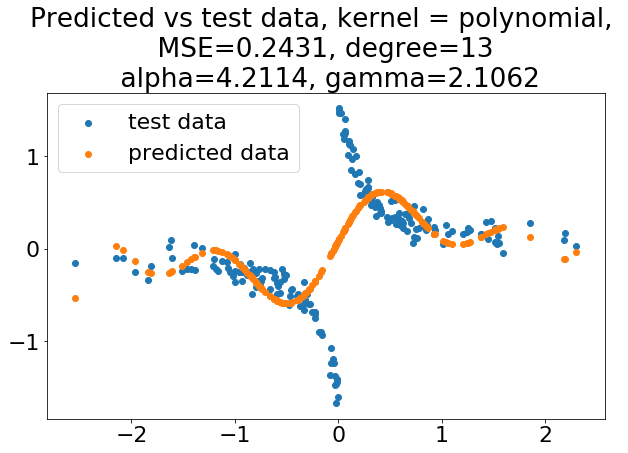

linear
linear alpha: 0.001 gamma: 0.001 MSE: 0.3401467216912169


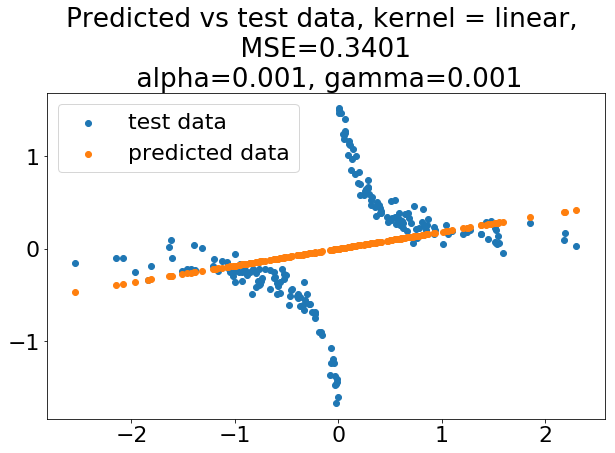

laplacian
laplacian alpha: 0.001 gamma: 40.0 MSE: 0.015674591681363897


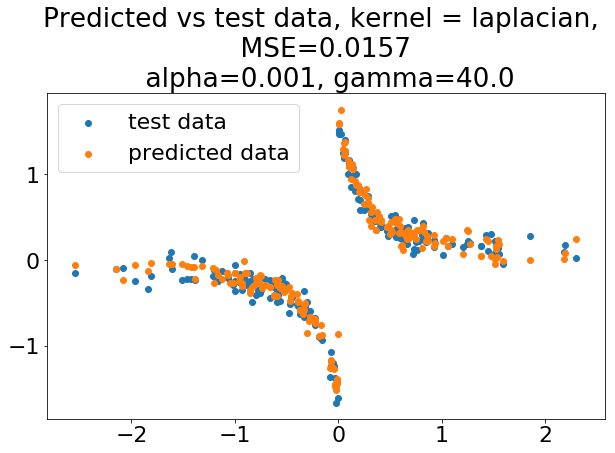

rbf
rbf alpha: 0.001 gamma: 40.0 MSE: 0.06622410455132303


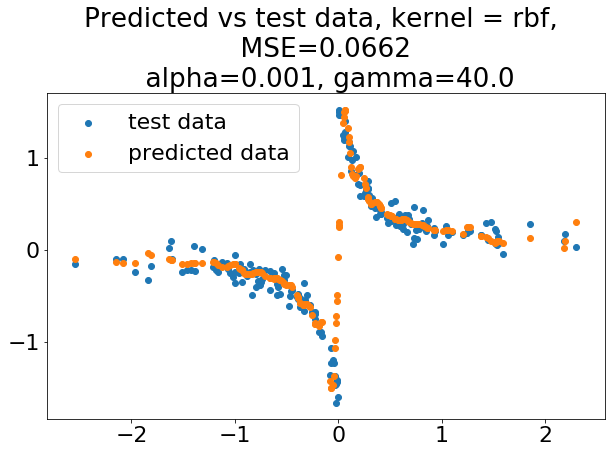

sigmoid
sigmoid alpha: 0.001 gamma: 35.78957894736842 MSE: 0.019499003052438398


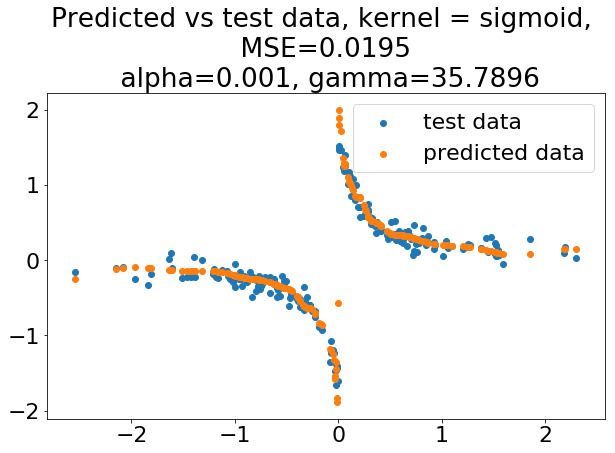

In [212]:
run_script(X_train, X_test, y_train, y_test)